# Resultados del análisis de correspondencia múltiple (MCA)

A continuación se muestran los resultados de la búsqueda de relaciones entre la
eficiencia del mercado y los indicadores de noticias. Para examinar la relación entre
los indicadores de noticias y los exponentes de Hurst se calcularon medidas para buscar similitudes o sincronía entre las series y, además, se usó MCA para obtener una
representación de las categorías de los indicadores.

## Metodología

La estrategia de trabajo comenzó con la adquisición de los valores del Índice de Precios y Cotizaciones (IPC) de la Bolsa Mexicana de Valores (BMV), así como la obtención de noticias de las plataformas financieras. En el proceso del análisis de la hipótesis de la eficiencia del mercado, se aplicó el algoritmo <i>Time-Scale Local Hurst Exponent</i> (TS-LHE) a la serie de retornos del IPC. Mientras que el proceso metodológico para la generación de los indicadores de noticias se dividió en dos fases distintas. En la primera fase, se llevó a cabo la modelación de tópicos, utilizando el contenido del cuerpo de las noticias. En la segunda etapa, se realizó un análisis de sentimiento en los títulos de las noticias. A continuación, en la siguiente tabla se proporciona una recopilación de la información de los indicadores de texto (indicadores de tópicos y de sentimiento).  Además, esta tabla definió una simbología con la que se identificó el indicador en las gráficas posteriores, el nombre del indicador, la sección o conjunto de datos empleado para crearlo y una breve descripción del indicador.

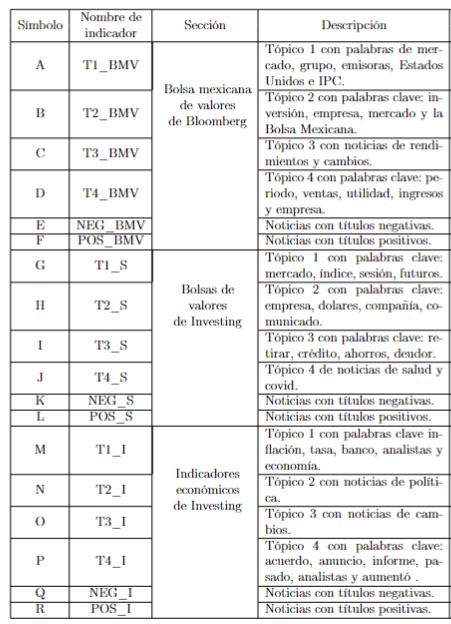

Tabla descriptiva de la información de los indicadores de noticias

Más adelante, se presentan las acciones utilizadas para realizar los análisis de correspondencia múltiple, buscando y explorando posibles tipos de patrones entre los exponentes de Hurst y los indicadores de noticias para conocer las relaciones entre la información textual y el comportamiento del mercado.

1. Estandarizar los indicadores de noticias. 

    En la primera metodología, se dividió el valor del indicador entre el número de noticias recopiladas en la semana de la sección correspondiente. En el segundo enfoque, se aplicó la siguiente fórmula a cada indicador $\{w_{it}\}$: 
    \begin{equation}
    \label{eq:maxmin}
        \frac{w_{it}-max(w_i)}{max(w_i)-min(w_i)}\text{.}
    \end{equation}

2. Encontrar escala óptima entre los indicadores de noticias y la serie de exponentes de Hurst.

    Se utilizaron tres métodos: la distancia de deformación dinámica del tiempo (DTW), la causalidad de Granger (GC) y la entropía entre muestras (CSE). Para cada método, se creó una matriz de resultados con los indicadores en las columnas y se calculó el promedio de las mediciones por fila, seleccionando la fila con el valor promedio más alto (o el más bajo en el caso de la entropía) como la escala óptima.


3. Categorizar los exponentes de Hurst en persistencia P+, eficiencia EMH y anti persistencia P-.

    Los exponentes de Hurst se categorizaron en tres grupos: 
    - Persistente (P+) si el exponente de la semana es mayor a $0.5+\hat{\sigma}(H)$
    - Eficiente (EMH) si encuentra entre $[0.5-\hat{\sigma}(H), 0.5+\hat{\sigma}(H)]$ 
    - Anti-persistente (P-) si es menor a $0.5-\hat{\sigma}(H)$ 
    
    donde $\hat{\sigma}(H) \approx \frac{1}{e\sqrt[3]{N}}$ 
    
4. Categorizar los indicadores de noticias en alto, intermedio y bajo.

    Los indicadores de noticias se categorizaron en tres niveles: bajo si el valor es menor a 0.25, medio si es entre 0.25 y 0.5 y alto si es mayor a 0.5. 


5. Crear la matriz indicadora de los datos

    Se creó una tabla con las 521 semanas de estudio en las filas y los indicadores de noticias junto con el exponente de Hurst categorizado se colocaron en las columnas. Luego, esta tabla se transformó en una matriz indicadora. 
    

6. Aplicar el análisis de correspondencia múltiple en la matriz indicadora.

    Se aplicó el análisis de correspondencia múltiple (MCA) sobre la matriz indicadora para generar una representación gráfica de las filas y columnas.

## Resultados al usar la estandarización por número de noticias

### Distancia DTW

Análisis de correspondencia múltiple sobre la matriz de los indicadores de noticias y la serie de exponentes óptima con base en la distancia DTW.
En este caso, al usar el criterio DTW la distancia se transformó al valor $(1 + d)^{−1}$, donde ’d’ denota la distancia DTW calculada con el algoritmo FastDTW. En consecuencia, cuando la distancia DTW es grande, el valor de $(1 + d)^{−1}$ tiende a aproximarse a cero, indicando que las series son bastante diferentes.

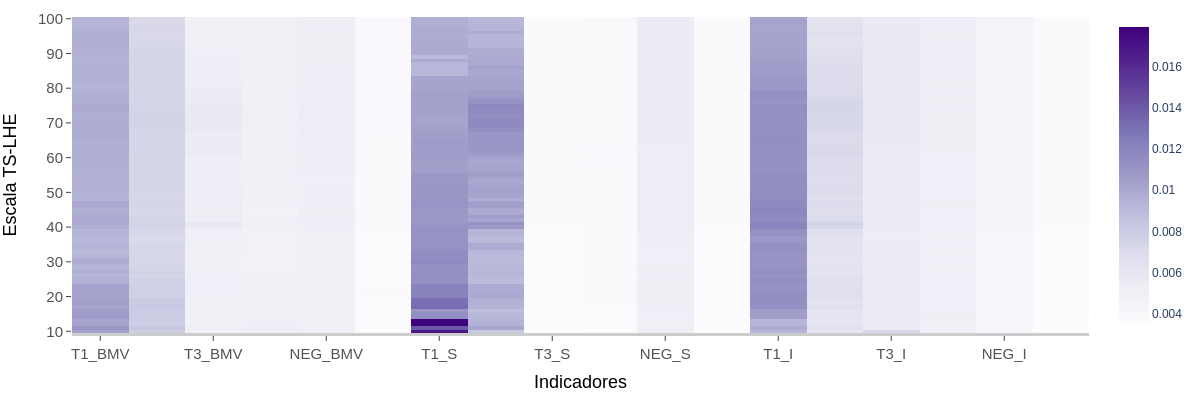

In [64]:
fig = px.imshow(M_coef_1,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])))
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Valores $(1+d)^{-1}$ donde $d$ es la distancia DTW estimada por el algoritmo FastDTW entre los indicadores de noticias y los exponentes de Hurst locales

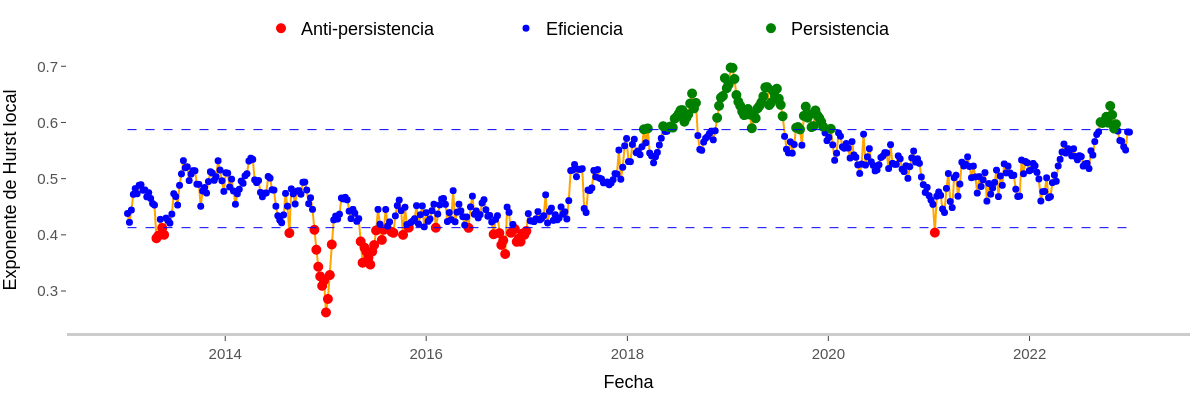

In [65]:
fig = go.Figure()
n = np.argmax(np.mean(M_coef_1,axis=1))
Hurst_kweek(n)

fig.update_layout(legend=dict(orientation="h",entrywidth=200,yanchor="bottom",y=1.0, xanchor="center",x=0.5,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

Serie de exponentes de Hurst locales con una escala de 75 semanas

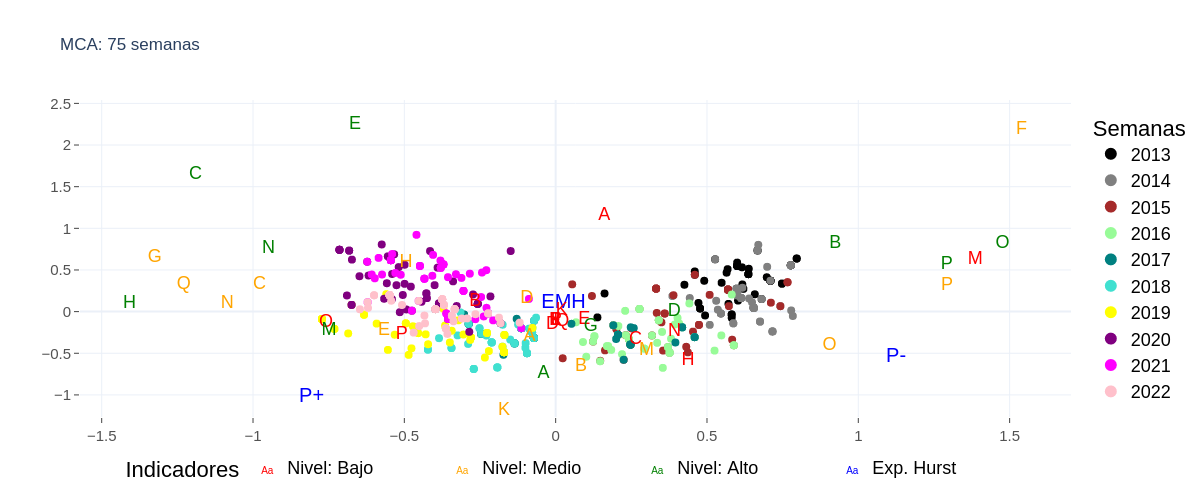

In [67]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Biplot de MCA con base en la distancia DTW

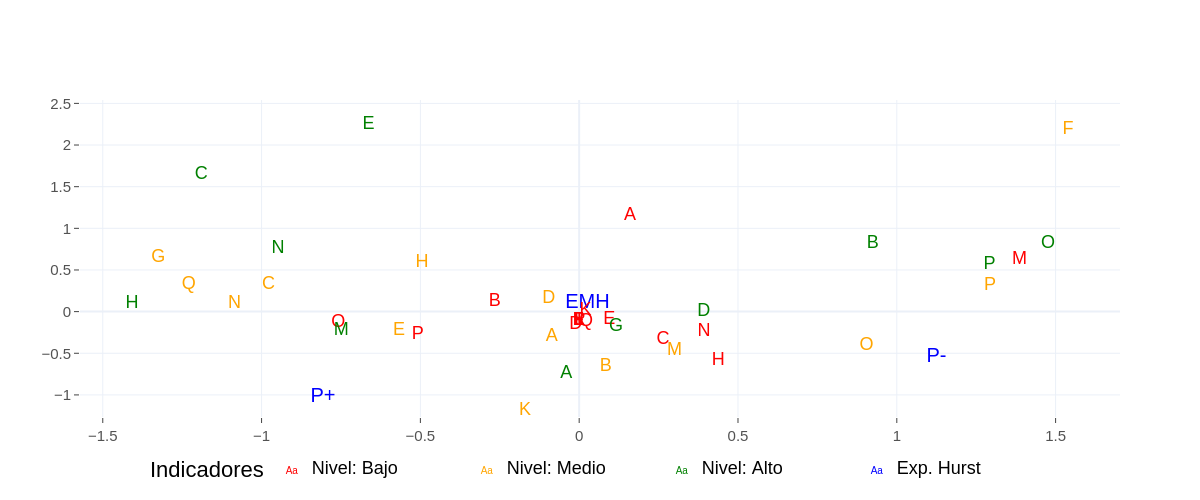

In [68]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

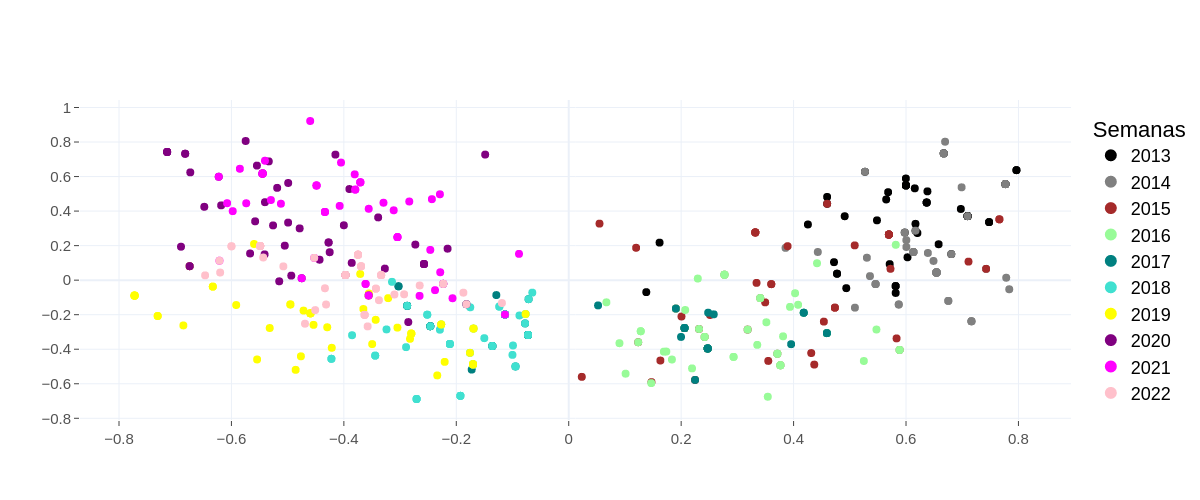

In [69]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)

### Granger Causality GC

Al usar la causalidad de Granger,
la medida consiste en el estadístico F en los casos en los que se rechazó la hipótesis
nula (considerando un p-valor igual a 0.1) de manera que el indicador influye (en
términos de causalidad de Granger) en la serie de exponentes de Hurst, utilizando un rezago de una semana (lag=1). Si no se encontró evidencia estadística para rechazar la hipótesis nula, se asignó un valor de 0.

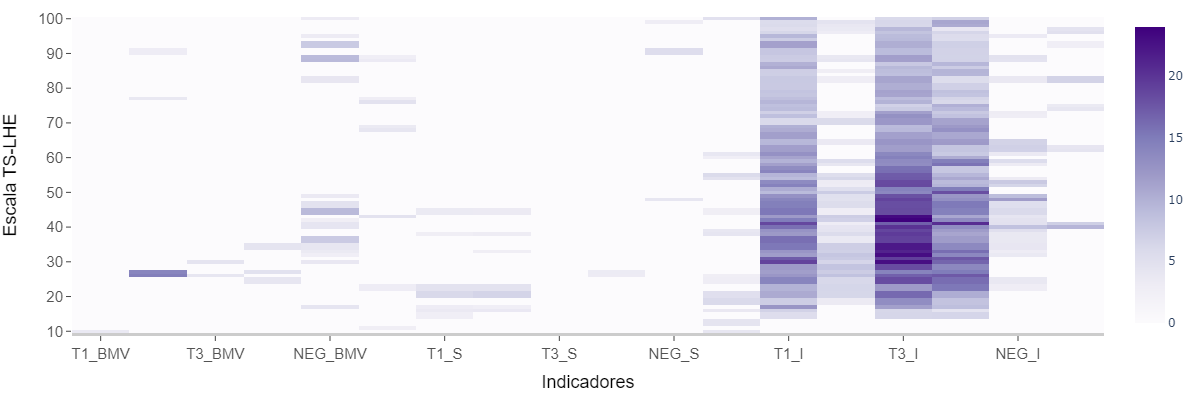

In [24]:
fig = px.imshow(M_coef_2,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])))
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Matriz con los valores del estadístico F cuando el indicador causa (en el sentido de Granger) la serie de exponentes de Hurst.

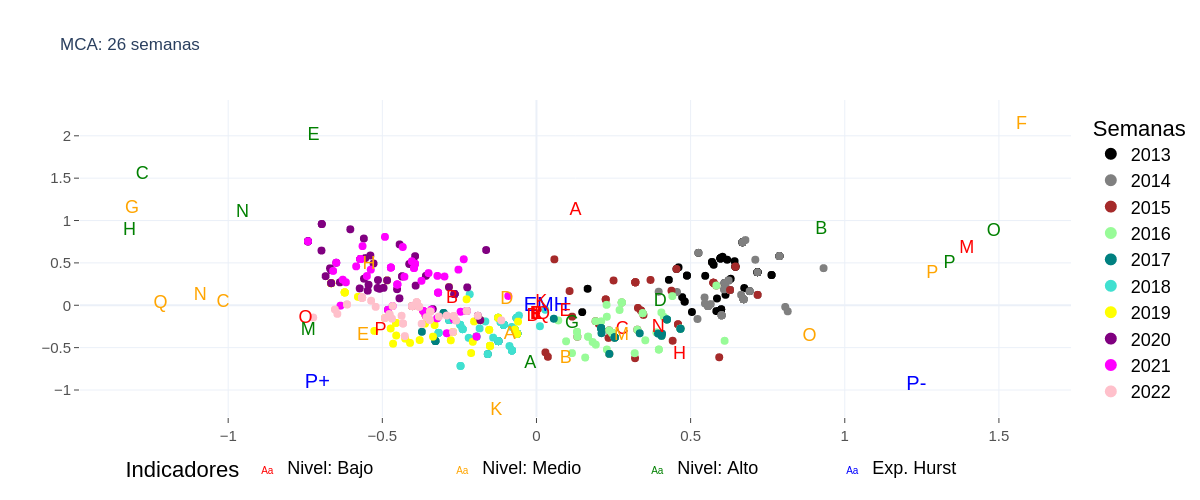

In [72]:
k_vecinos = np.argmax(np.mean(M_coef_2,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de aplicar MCA sobre la matriz indicadora de los indicadores y la serie de exponentes óptima con base en la causalidad de Granger.

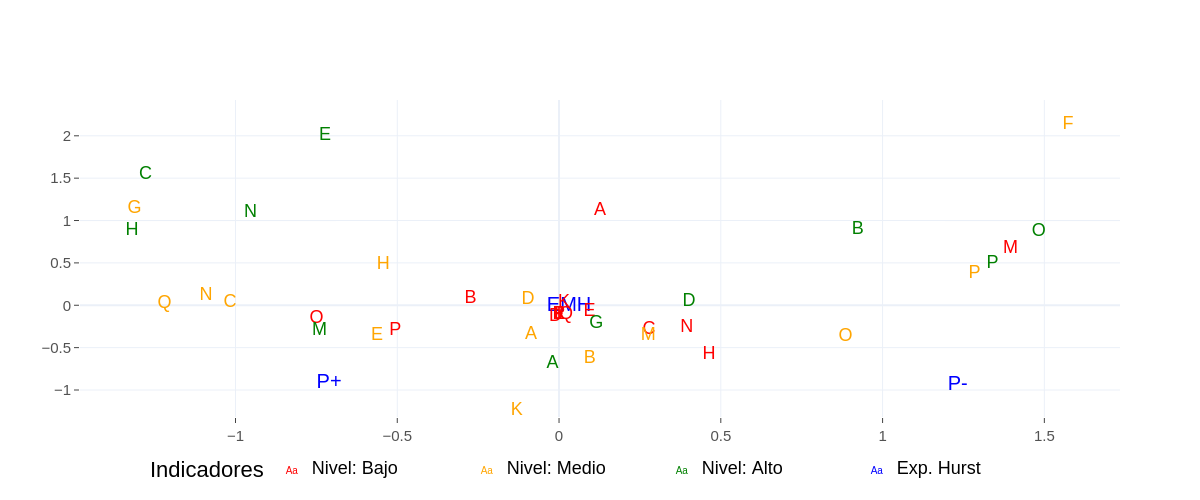

In [74]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

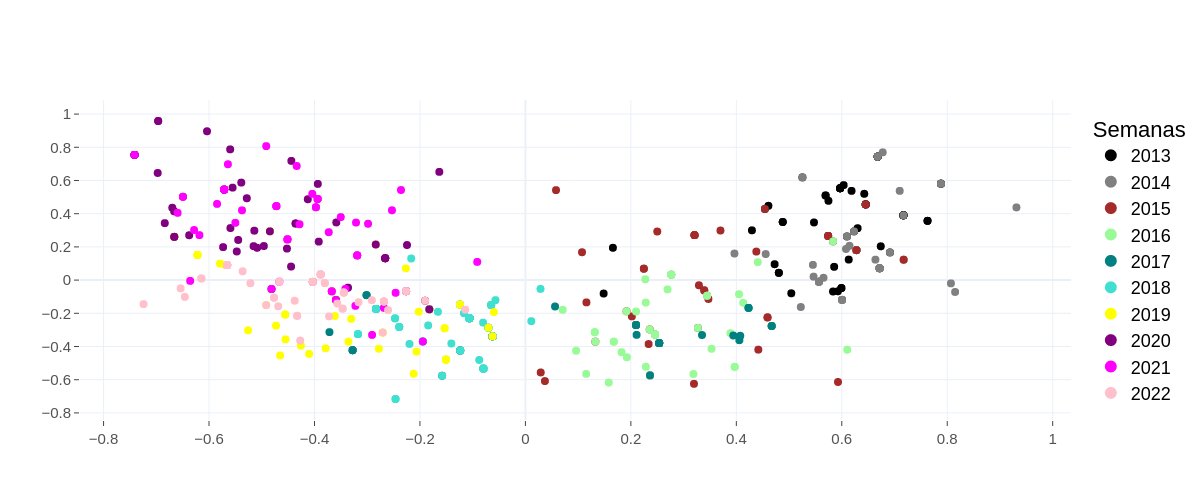

In [73]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)

### Entropia entre muestras

Al emplear la entropía cruzada
la medida contienen el promedio de la estimación de la entropía entre muestras de la serie de exponentes de Hurst y los indicadores de noticias tomando como dimensión de embedding los valores uno y dos, así como un tiempo de rezago igual a uno y un umbral de tolerancia (la tolerancia es de $0.2 ∗ \sigma$ donde $\sigma$ es el error estándar de los
exponentes de Hurst)

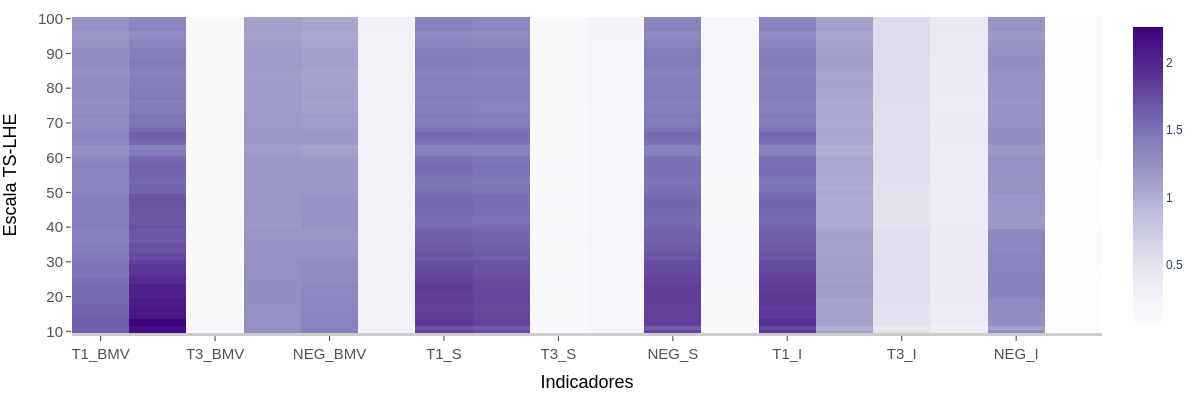

In [75]:
fig = px.imshow(M_coef_3,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])),)
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Matriz con la estimación de la entropía entre muestras de los indicadores y los exponentes de Hurst locales.

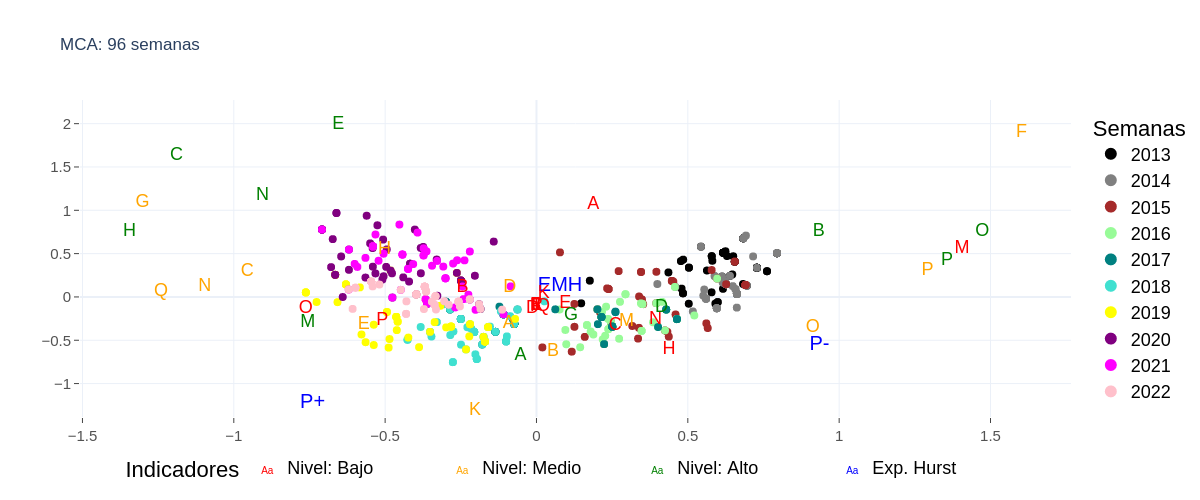

In [77]:
k_vecinos = np.argmin(np.mean(M_coef_3,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de aplicar MCA sobre la matriz indicadora de los indicadores y la serie de exponentes óptima con base en la entropía entre muestras.

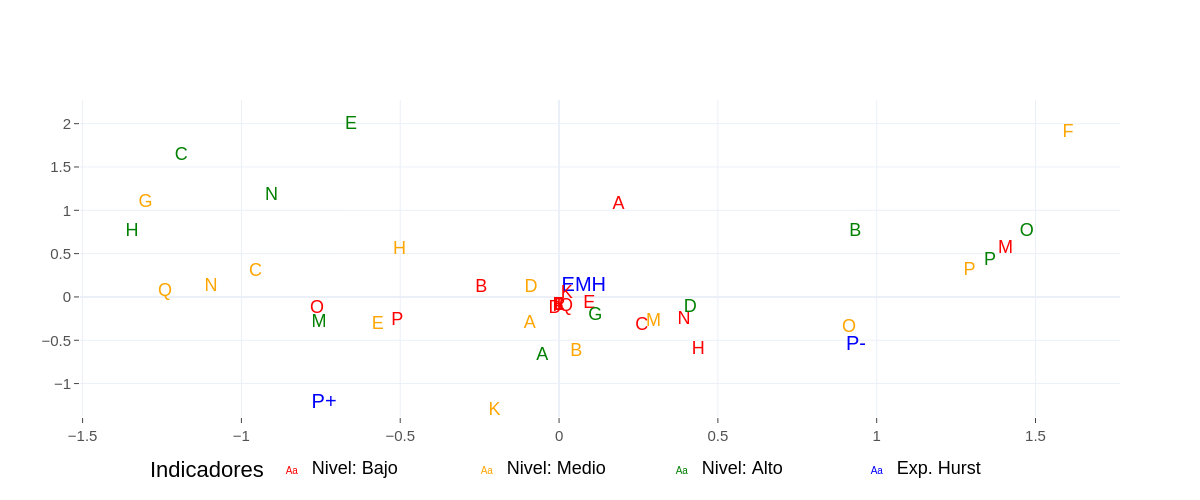

In [79]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

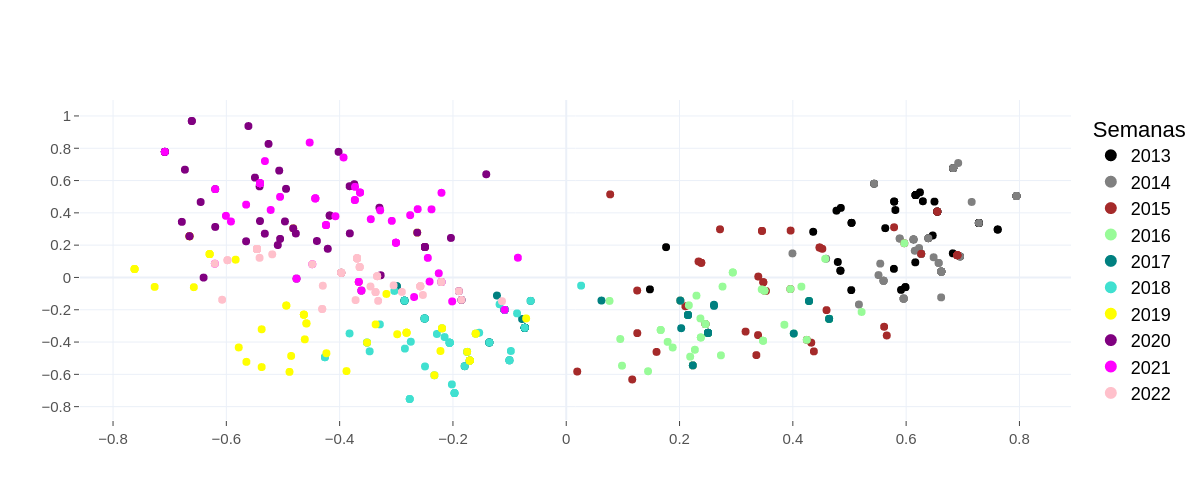

In [78]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)

## Resultados al usar la estandarización MAX-MIN

### Distancia DTW

Análisis de correspondencia múltiple sobre la matriz creada con los indicadores estandarizados (fórmula max-min) y la serie de exponentes de Hurst óptima con base en la distancia DTW.

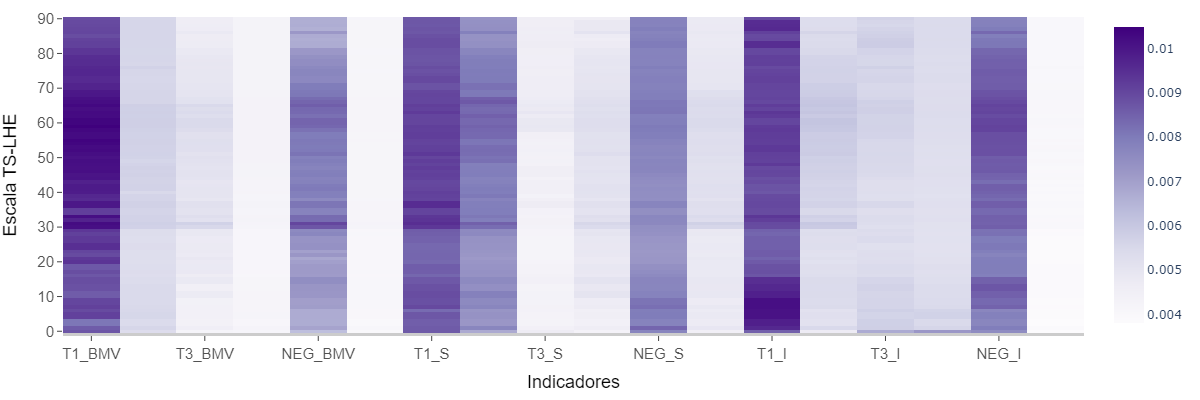

In [20]:
fig = px.imshow(M2_coef_1,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Valores $(1+d)^{-1}$ donde $d$ es la distancia DTW entre los indicadores de noticias estandarizados (fórmula max-min) y los exponentes de Hurst locales.

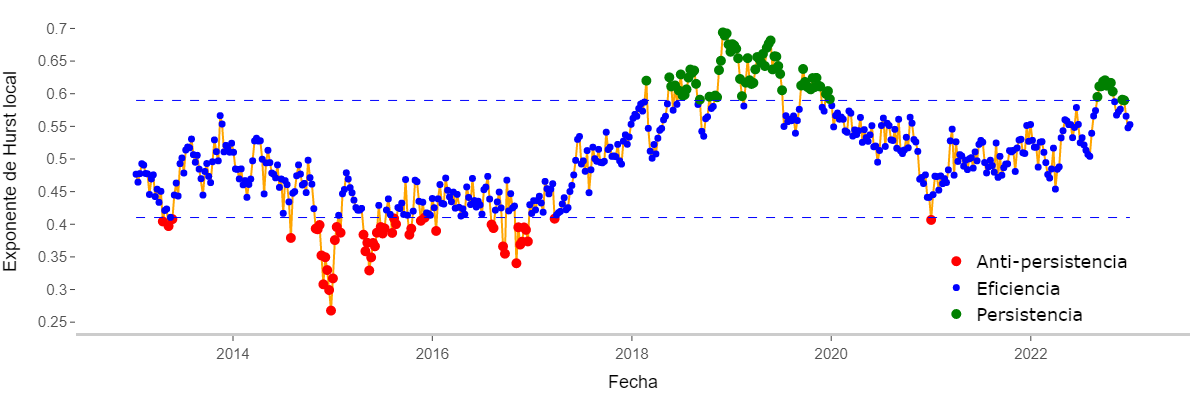

In [22]:
fig = go.Figure()
Hurst_kweek(np.argmax(np.mean(M2_coef_1,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

Serie de exponentes de Hurst locales con una escala de 69 semanas.

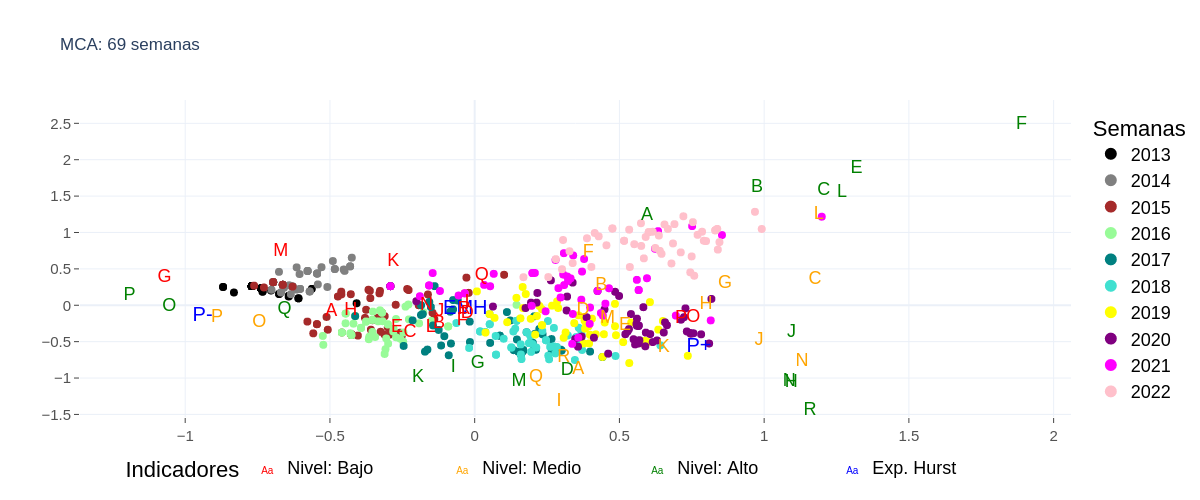

In [86]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representaciones de las filas y columnas obtenidas con MCA sobre la matriz creada con los indicadores de noticias estandarizados (fórmula max-min) y la serie de exponentes óptima con base en la distancia DTW.

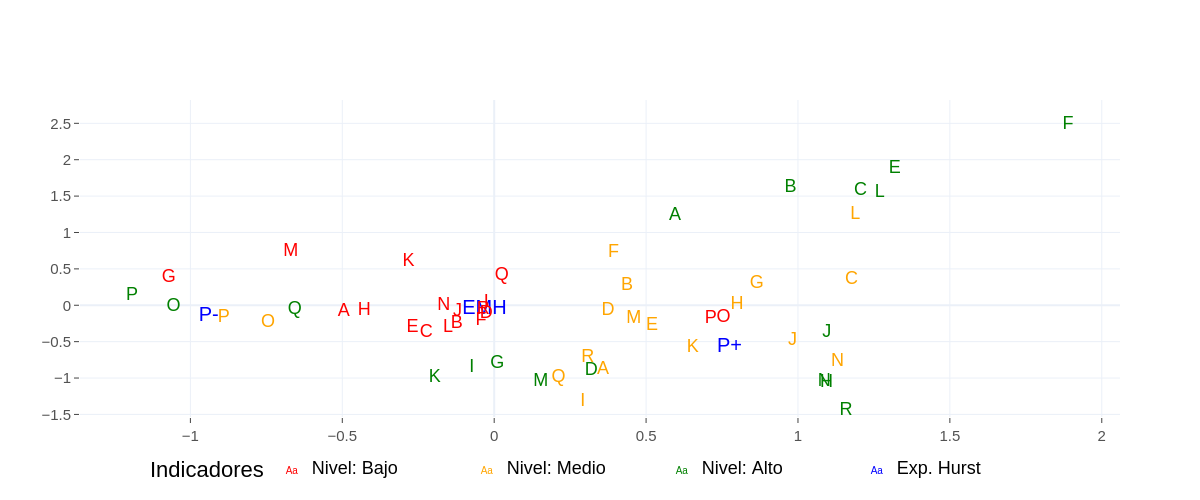

In [87]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

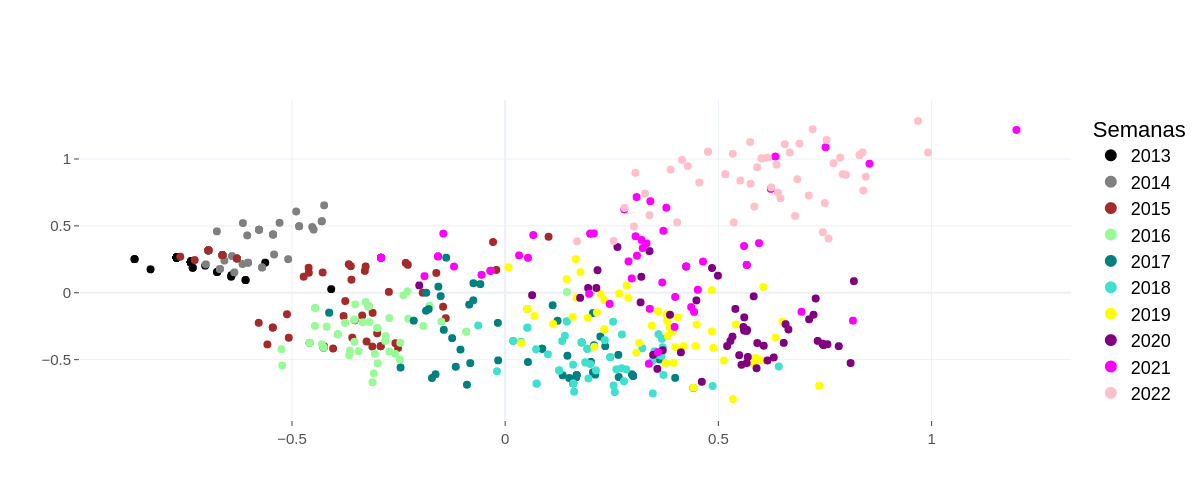

In [88]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)

### Granger Causality

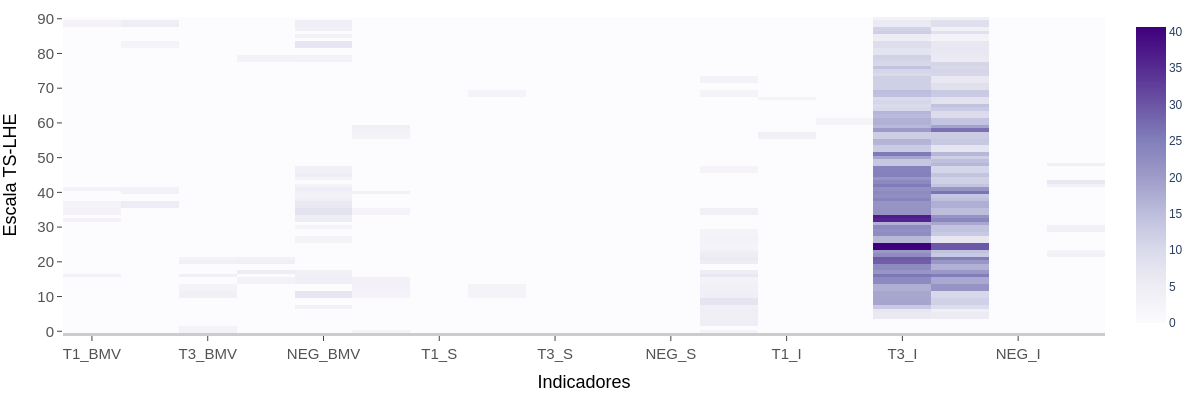

In [89]:
fig = px.imshow(M2_coef_2,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Valores del estadístico F cuando el indicador estandarizado (con la fórmula max-min) causa (en el sentido de Granger) la serie de exponentes de Hurst.

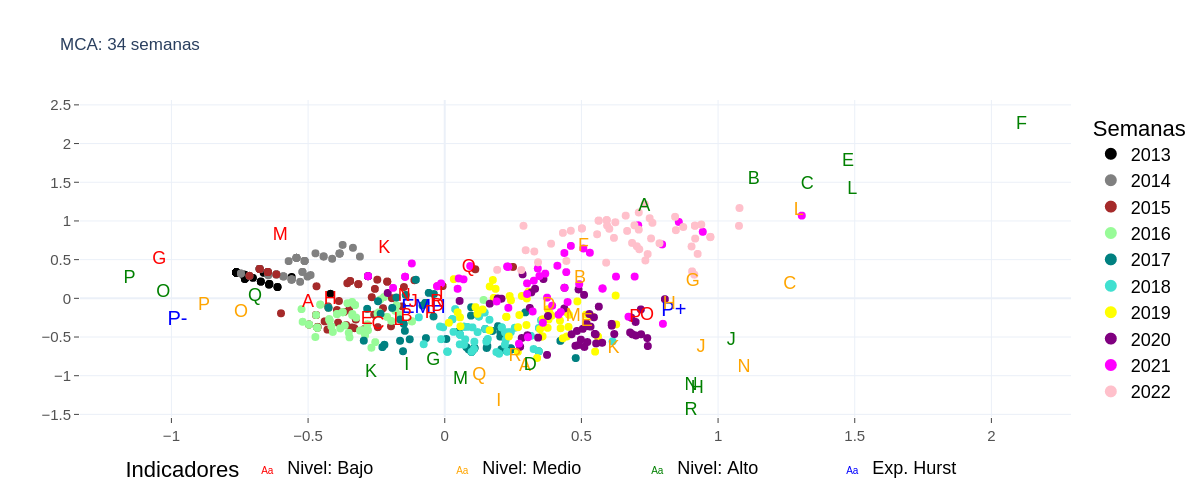

In [91]:
k_vecinos = np.argmax(np.mean(M2_coef_2,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de aplicar MCA sobre la matriz indicadora de los indicadores estandarizados (con la fórmula max-min) y la serie de exponentes óptima con base en la causalidad de Granger.

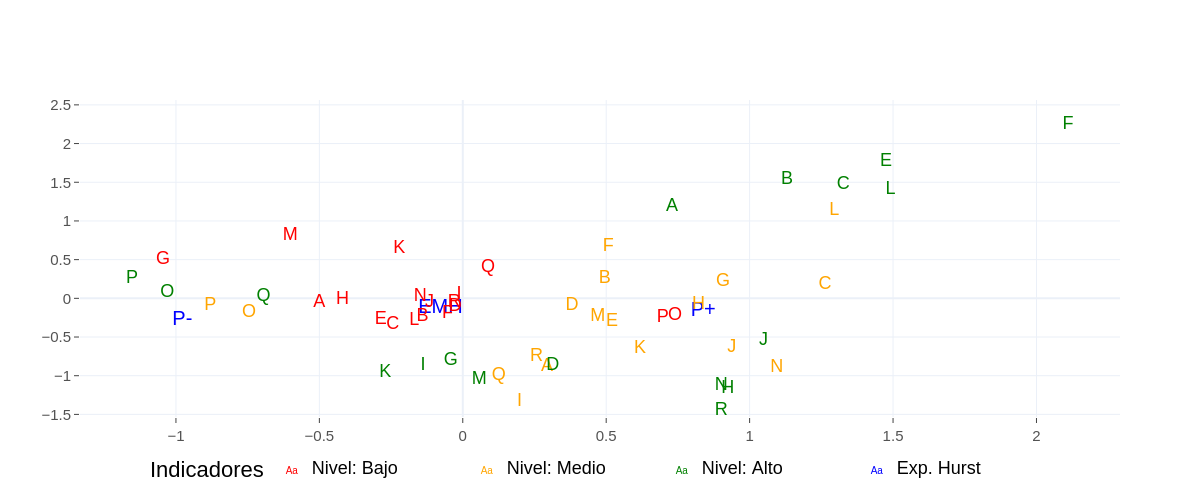

In [92]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

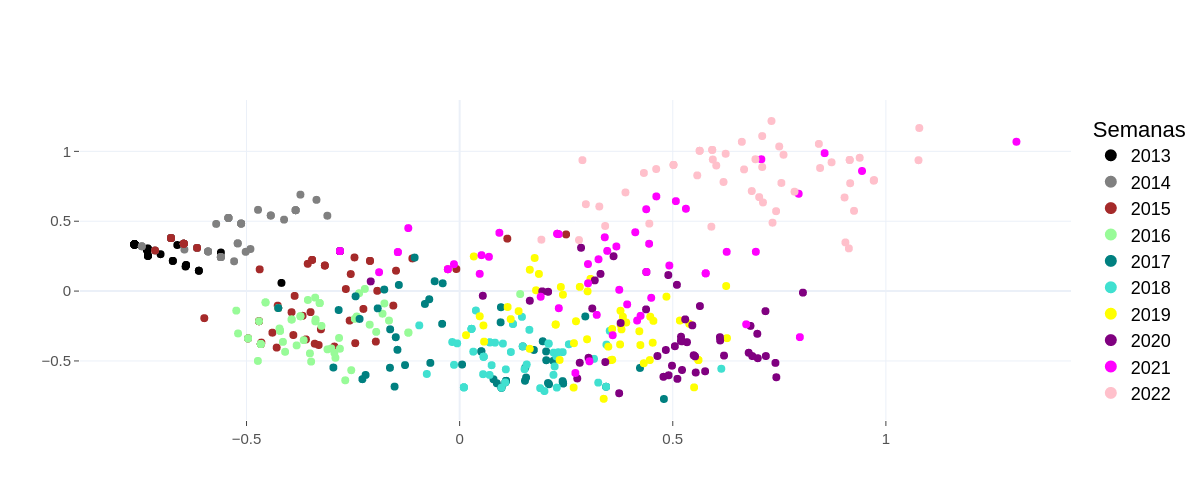

In [93]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)

### Entropia entre muestras

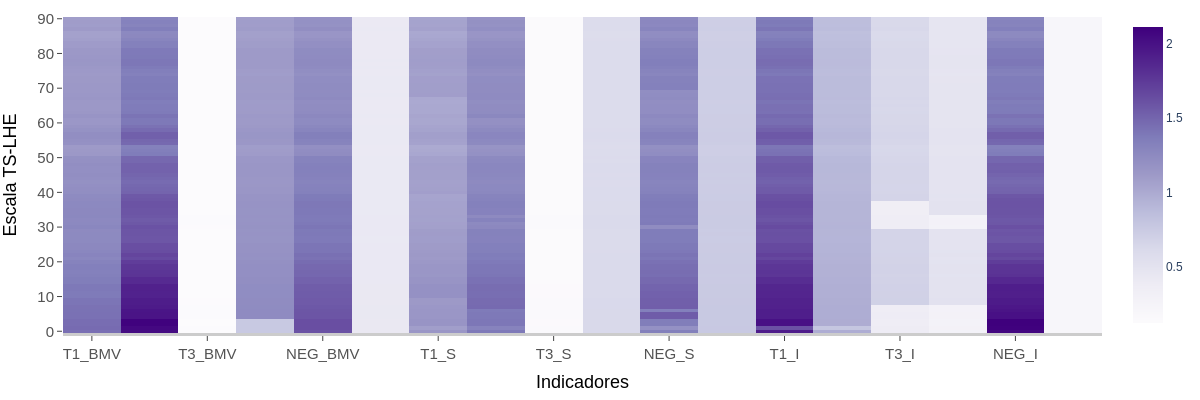

In [94]:
fig = px.imshow(M2_coef_3,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

Matriz con la estimación de la entropía entre muestras de los indicadores estandarizados (con la fórmula max-min) y los exponentes de Hurst locales.

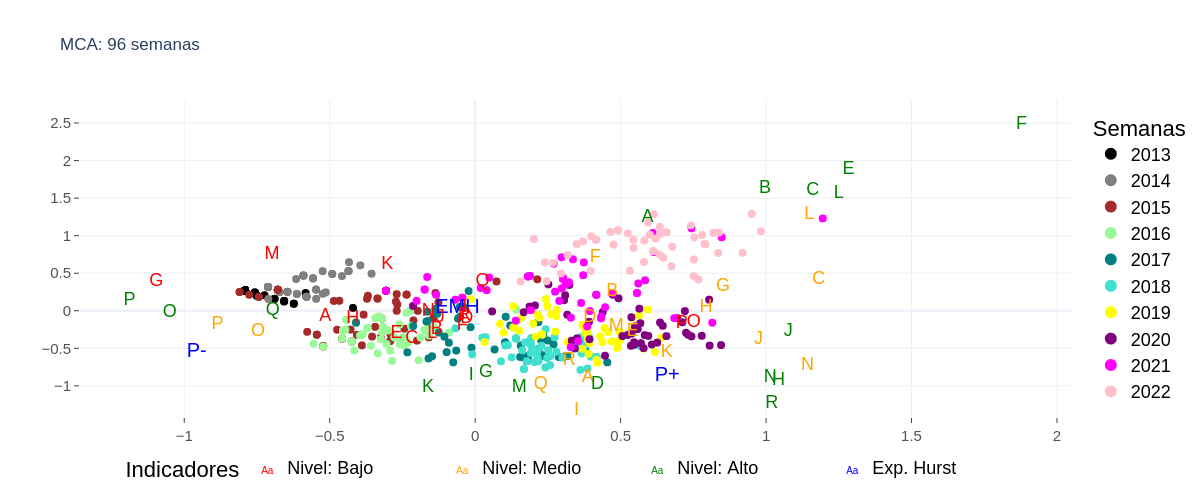

In [97]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de aplicar MCA sobre la matriz indicadora de los indicadores estandarizados (con la fórmula max-min) y la serie de exponentes óptima con base en la entropía entre muestras.

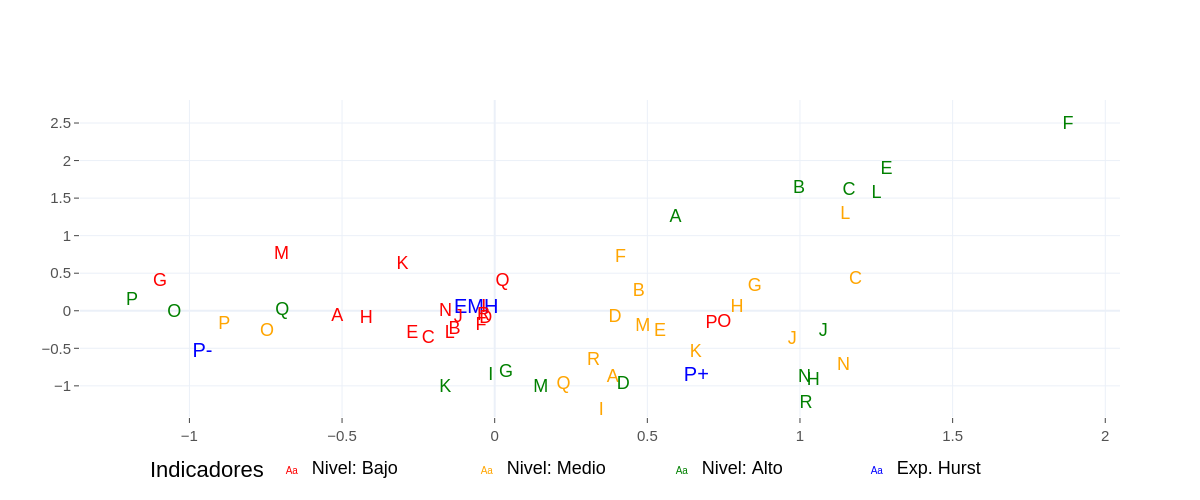

In [98]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA los indicadores (columnas de la matriz indicadoras).

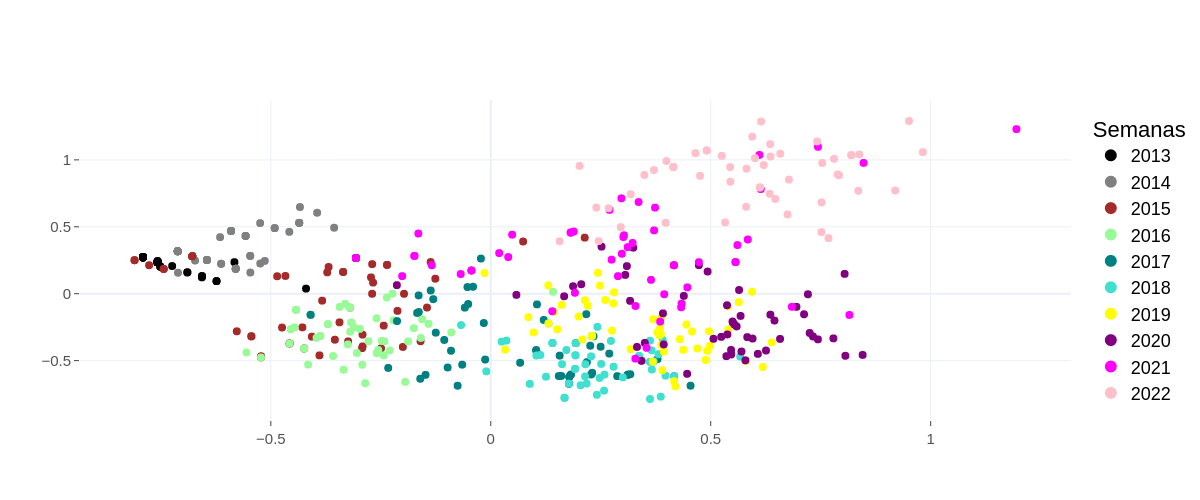

In [99]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

Representación obtenida de MCA de los años (filas de la matriz indicadoras)